<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/ISIC2017_new_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



# Get Data

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import csv
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as app
seed = 1234
np.random.seed(seed)

In [2]:
from zipfile import ZipFile
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_id = '1bbKAqUuk7Y1q3xsDSwP07oOXN_GL3SQM'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dada')
with ZipFile('dada', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1m0u6Ic9ZoF-FS-_HRfIHKMdxNXztWLe7'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ISIC2017')
with ZipFile('ISIC2017', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1TPLVTEzAgEcFFM2KJ5ijaCzW1oY6a_wX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('training_mask')
with ZipFile('training_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)

In [ ]:
os.remove("/content/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv")

# Initial Data

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [4]:
def GetFiles(path):
    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list

def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name.replace(".jpg",".png"))
    #print(mask_path)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    _,img_mask = cv2.threshold(img_mask,127,255,cv2.THRESH_BINARY)
    img_mask = img_mask/255
    return img_mask


def build_data(path,mask_folder,csv_path,img_shapes):
  w,h = img_shapes
  imgs=[]
  masks=[]
  img_name=[]
  if csv_path == None:
    img_name = os.listdir(path)
  else:
    with open(csv_path, 'r') as csvFile:
      reader = csv.reader(csvFile)
      for row in reader:
          img_name.append(row[0])
  n = len(img_name)//20
  for count,file in enumerate(img_name[:]):
        if file.find("super")>0:
          continue
        fullpath= os.path.join(path,file)
        #print(fullpath)
        msk=get_mask(file,mask_folder)
        msk=cv2.resize(msk,(w,h))
        masks.append(msk)
        image=cv2.imread(fullpath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image=image/127.5-1
        image=cv2.resize(image,(w,h))
        imgs.append(image)
        if count%n == 0:
          plt.figure(count//n)
          plt.subplot(1,2,1).imshow(image,cmap='gray')
          #plt.contour(msk,colors='r')
          #plt.draw()
          plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
          plt.show()  
  imgs=np.asarray(imgs,dtype=np.float)
  masks=np.asarray(masks,dtype=np.float).reshape(-1,h,w,1)
  print("shape imgs: ",imgs.shape)
  print("shape masks: ",masks.shape)
  return imgs,masks

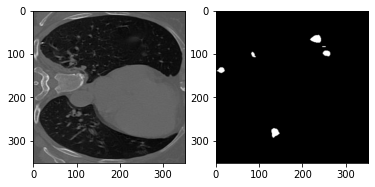

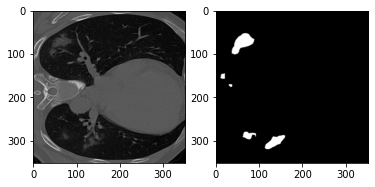

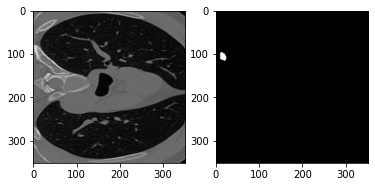

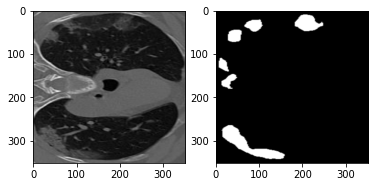

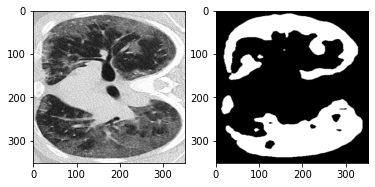

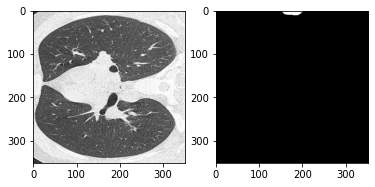

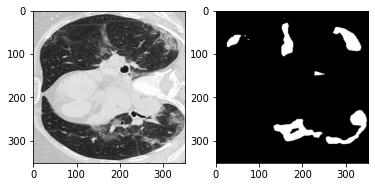

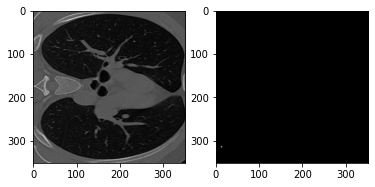

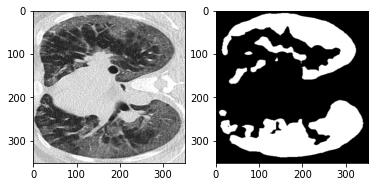

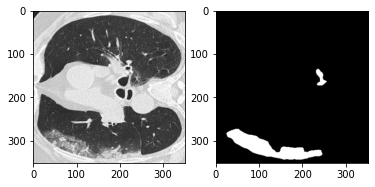

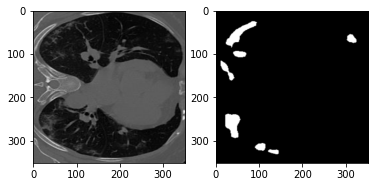

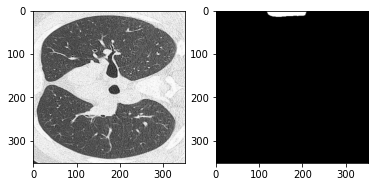

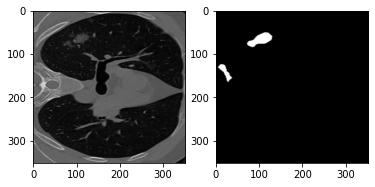

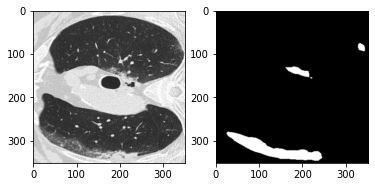

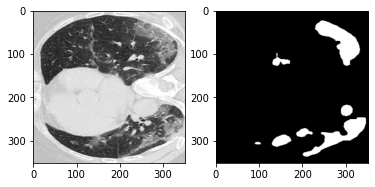

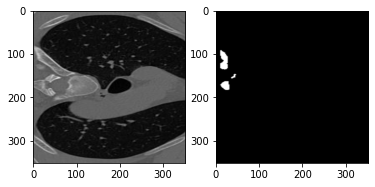

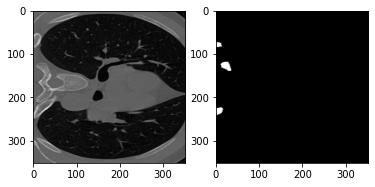

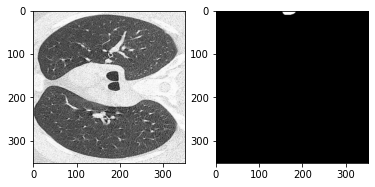

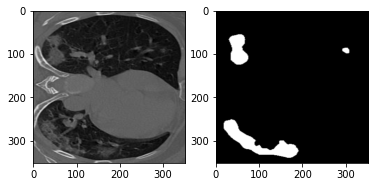

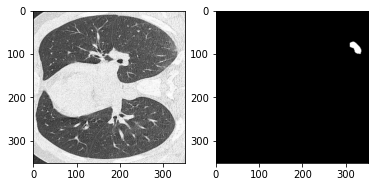

shape imgs:  (1600, 352, 352, 3)
shape masks:  (1600, 352, 352, 1)
---------------------------------------------------------


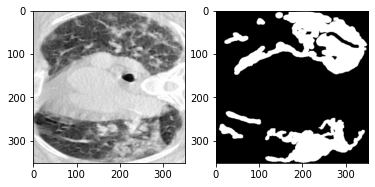

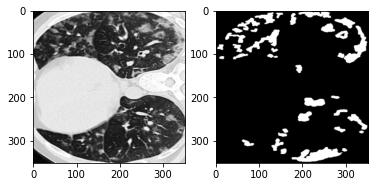

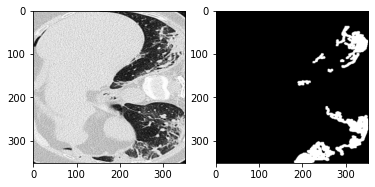

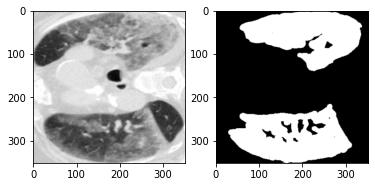

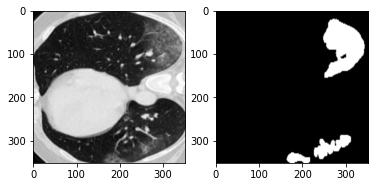

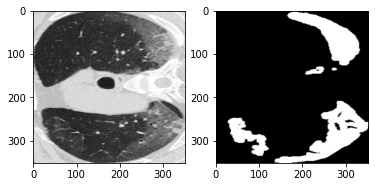

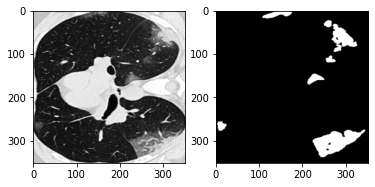

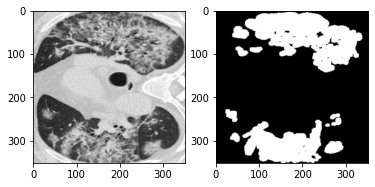

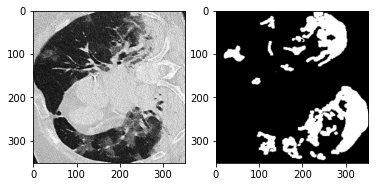

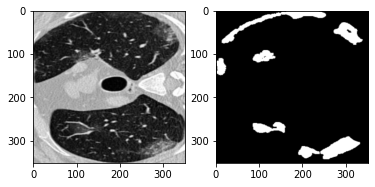

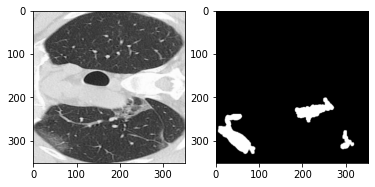

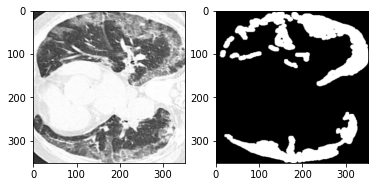

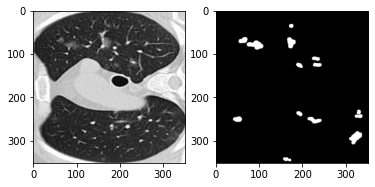

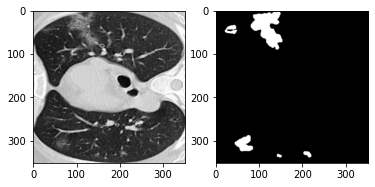

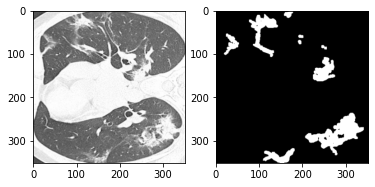

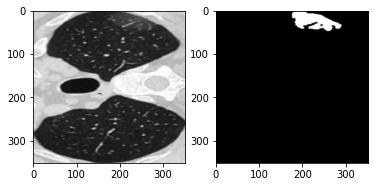

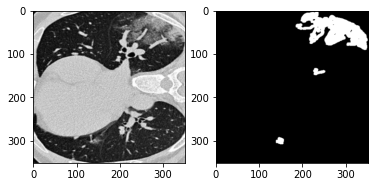

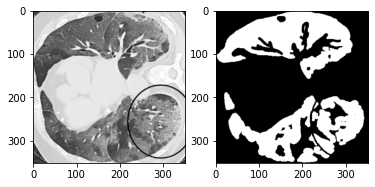

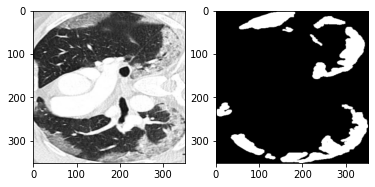

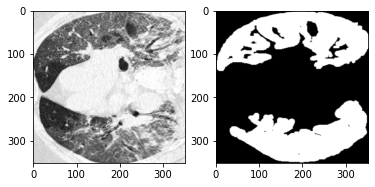

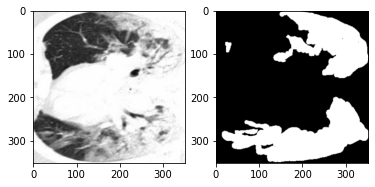

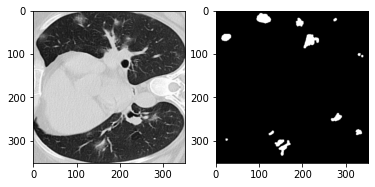

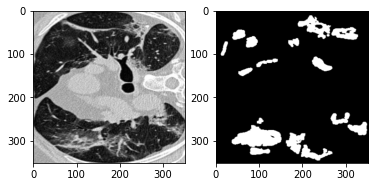

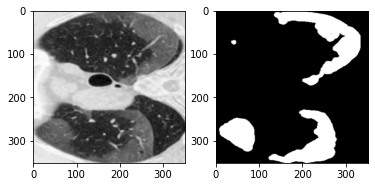

shape imgs:  (48, 352, 352, 3)
shape masks:  (48, 352, 352, 1)


In [5]:
w = 352
h = 352
folder_train = "/content/COVID-SemiSeg/Dataset/TrainingSet/LungInfection-Train/Pseudo-label/Imgs"
mask_train_folder = "/content/COVID-SemiSeg/Dataset/TrainingSet/LungInfection-Train/Pseudo-label/GT"
#csv_train = '/content/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv'
folder_test = "/content/COVID-SemiSeg/Dataset/TestingSet/LungInfection-Test/Imgs"
mask_test_folder = "/content/COVID-SemiSeg/Dataset/TestingSet/LungInfection-Test/GT"
# folder_train = "/content/ISIC-2017_Training_Data"
# mask_train_folder = "/content/ISIC-2017_Training_Part1_GroundTruth"
imgs,masks = build_data(folder_train,mask_train_folder, None, (w,h))
print("---------------------------------------------------------")
img_dev,mask_dev = build_data(folder_test,mask_test_folder, None, (w,h))



#loss

In [6]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=1.0):
    '''Average dice coefficient per batch.'''
    y_pred = heviside(y_pred,epsilon = 0.01)
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=1.0)
def gradientLoss2d(input):
    dH = K.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = K.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    dH = dH * dH
    dW = dW * dW
    loss = K.sum(dH) + K.sum(dW)
    return loss
def levelsetLoss(y_true, y_pred, ratio = 0.001):
    #print("go")
    outshape = y_pred.shape
    tarshape = y_true.shape
    multi = y_true*y_pred
    c_numerator = K.sum(multi, [1,2])
    c_denominator = K.sum(y_pred, [1,2])
    #print("outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape")
    #print(outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape)
    c = c_numerator/c_denominator
    #print("s",c.shape)
    c = K.reshape(c, (-1, 1, 1,outshape[3])) 
    #print("c.shape: ", c.shape)
    plevel = y_true - c
    #print("plevel: ", plevel)
    pLoss = plevel * plevel * y_pred
    lossL = K.mean(pLoss)
    #print("lossL: ", lossL)
    lossA = gradientLoss2d(y_pred) * ratio

    return lossL  + dice_coef_loss(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_pred = y_pred[0]
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
def heviside(x,epsilon=0.1):
    return 1/2*(1+2/3.14159*tf.math.atan(x/epsilon))
def Active_Contour_Loss(y_true, y_pred): 
    epison = 0.1
    Drc = (epison / 3.14159) / (epison * epison + y_pred[:,:,:,0] * y_pred[:,:,:,0])
    Hea = 1/2*(1+2/3.14159*tf.math.atan(y_pred[:,:,:,0]/0.1))
    #Hea = y_pred[:,:,:,0]
    """
    lenth term
    """

    x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:] # horizontal and vertical directions 
    y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:]

    delta_x = x[:,1:,:-2,:]**2
    delta_y = y[:,:-2,:1,:]**2
    delta_u = K.abs(delta_x + delta_y) 

    lenth = K.mean(K.sqrt(delta_u + 0.00000001)) # equ.(11) in the paper

    """y_pred
    region term
    """

    C_1 = np.ones((h, w))
    C_2 = np.zeros((h, w))

    region_in = K.abs(K.mean( Hea * ((y_true[:,:,:,0] - C_1)**2) ) ) # equ.(12) in the paper
    region_out = K.abs(K.mean( (1-Hea) * ((y_true[:,:,:,0] - C_2)**2) )) # equ.(12) in the paper

    lambdaP = 1 # lambda parameter could be various.
    mu = 1 # mu parameter could be various.
    
    return lambdaP * (mu * region_in + 2*region_out) 






# Data Augument

In [7]:
#from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

#attention gate

In [8]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)


    f = Activation('relu')(add([theta_x, phi_g]))


    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x

#callback

In [9]:
class lr_scheduler(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))


class visualize(tf.keras.callbacks.Callback):


    def __init__(self,img):
        super(visualize, self).__init__()
        self.img = img
    def on_epoch_end(self, epoch, logs=None):
       feature_maps = self.model.predict(img)
       fm = feature_maps[0]
       fm = heviside(fm)
       #print(fm.shape)
       square = 2
       print("------------------------")
       #print(feature_maps[-1][0,:3,:3,0])
       print("-------------------------")
       #print(feature_maps[0][0,:3,:3,0])
       plt.imshow(fm[:,:,0],cmap = 'gray')
       plt.show()
      #  for fmap in feature_maps[1:]:
      #       ix = 1
      #       for _ in range(square):
      #           for _ in range(square):
      #               # specify subplot and turn of axis
      #               ax = plt.subplot(square, square, ix)
      #               ax.set_xticks([])
      #               ax.set_yticks([])
      #               # plot filter channel in grayscale
      #               if ix > fmap.shape[-1]:
      #                   continue
      #               plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
      #               ix += 1
      #       plt.show()




In [10]:

def unet(input_size = (192,288,3),classnum=2,pretrained_weights = None):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    merge6 = attention_up_and_concate(conv5,conv4)
    conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    merge7 = attention_up_and_concate(conv6,conv3)
    conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    merge8 = attention_up_and_concate(conv7,conv2)
    conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    merge9 = attention_up_and_concate(conv8,conv1)
    conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(1, 1,name = "main_output")(conv9)
    #out = tf.keras.layers.Activation("sigmoid",name = "main_output")(conv10)
    model = Model(inputs = data, outputs = conv10)

    
    
   # model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

Epoch 1/80
400/400 [==============================] - ETA: 0s - loss: 0.0747 - binary_accuracy: 0.9602 - dice_coef: 0.0031------------------------
-------------------------


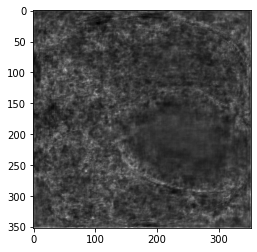


Epoch 00001: val_dice_coef improved from -inf to 0.00106, saving model to weights_save/unet.01_0.00.h5
400/400 [==============================] - 172s 430ms/step - loss: 0.0747 - binary_accuracy: 0.9602 - dice_coef: 0.0031 - val_loss: 0.3136 - val_binary_accuracy: 0.8300 - val_dice_coef: 0.0011
Epoch 2/80
400/400 [==============================] - ETA: 0s - loss: 0.0696 - binary_accuracy: 0.9612 - dice_coef: 0.0026------------------------
-------------------------


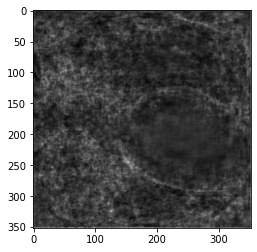


Epoch 00002: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0696 - binary_accuracy: 0.9612 - dice_coef: 0.0026 - val_loss: 0.3131 - val_binary_accuracy: 0.8300 - val_dice_coef: 8.7499e-04
Epoch 3/80
400/400 [==============================] - ETA: 0s - loss: 0.0692 - binary_accuracy: 0.9611 - dice_coef: 0.0028------------------------
-------------------------


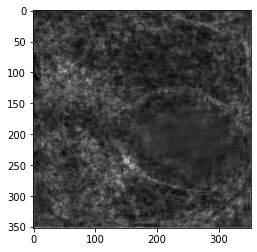


Epoch 00003: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0692 - binary_accuracy: 0.9611 - dice_coef: 0.0028 - val_loss: 0.3128 - val_binary_accuracy: 0.8300 - val_dice_coef: 7.8209e-04
Epoch 4/80
400/400 [==============================] - ETA: 0s - loss: 0.0681 - binary_accuracy: 0.9615 - dice_coef: 0.0029------------------------
-------------------------


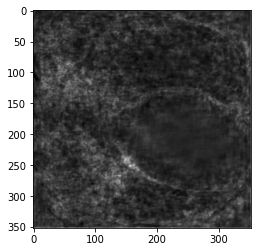


Epoch 00004: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0681 - binary_accuracy: 0.9615 - dice_coef: 0.0029 - val_loss: 0.3126 - val_binary_accuracy: 0.8300 - val_dice_coef: 7.2749e-04
Epoch 5/80
400/400 [==============================] - ETA: 0s - loss: 0.0683 - binary_accuracy: 0.9613 - dice_coef: 0.0028------------------------
-------------------------


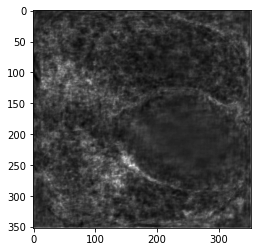


Epoch 00005: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0683 - binary_accuracy: 0.9613 - dice_coef: 0.0028 - val_loss: 0.3125 - val_binary_accuracy: 0.8300 - val_dice_coef: 6.9757e-04
Epoch 6/80
400/400 [==============================] - ETA: 0s - loss: 0.0682 - binary_accuracy: 0.9612 - dice_coef: 0.0030------------------------
-------------------------


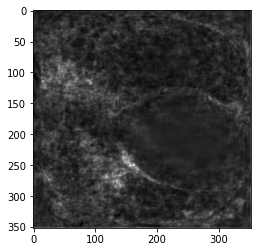


Epoch 00006: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0682 - binary_accuracy: 0.9612 - dice_coef: 0.0030 - val_loss: 0.3124 - val_binary_accuracy: 0.8300 - val_dice_coef: 6.8682e-04
Epoch 7/80
400/400 [==============================] - ETA: 0s - loss: 0.0681 - binary_accuracy: 0.9612 - dice_coef: 0.0031------------------------
-------------------------


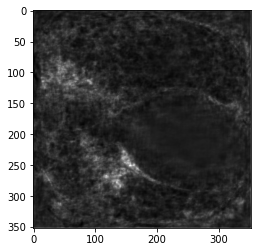


Epoch 00007: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0681 - binary_accuracy: 0.9612 - dice_coef: 0.0031 - val_loss: 0.3122 - val_binary_accuracy: 0.8300 - val_dice_coef: 7.0033e-04
Epoch 8/80
400/400 [==============================] - ETA: 0s - loss: 0.0675 - binary_accuracy: 0.9614 - dice_coef: 0.0034------------------------
-------------------------


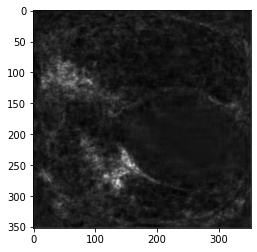


Epoch 00008: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0675 - binary_accuracy: 0.9614 - dice_coef: 0.0034 - val_loss: 0.3121 - val_binary_accuracy: 0.8300 - val_dice_coef: 7.5958e-04
Epoch 9/80
400/400 [==============================] - ETA: 0s - loss: 0.0674 - binary_accuracy: 0.9614 - dice_coef: 0.0034------------------------
-------------------------


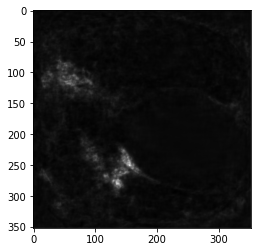


Epoch 00009: val_dice_coef did not improve from 0.00106
400/400 [==============================] - 165s 412ms/step - loss: 0.0674 - binary_accuracy: 0.9614 - dice_coef: 0.0034 - val_loss: 0.3118 - val_binary_accuracy: 0.8300 - val_dice_coef: 0.0010
Epoch 10/80
400/400 [==============================] - ETA: 0s - loss: 0.0670 - binary_accuracy: 0.9614 - dice_coef: 0.0054------------------------
-------------------------


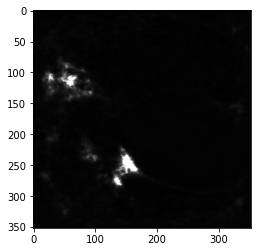


Epoch 00010: val_dice_coef improved from 0.00106 to 0.00318, saving model to weights_save/unet.10_0.00.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0670 - binary_accuracy: 0.9614 - dice_coef: 0.0054 - val_loss: 0.3096 - val_binary_accuracy: 0.8300 - val_dice_coef: 0.0032
Epoch 11/80
400/400 [==============================] - ETA: 0s - loss: 0.0665 - binary_accuracy: 0.9614 - dice_coef: 0.0074------------------------
-------------------------


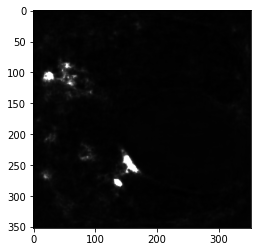


Epoch 00011: val_dice_coef improved from 0.00318 to 0.00383, saving model to weights_save/unet.11_0.00.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0665 - binary_accuracy: 0.9614 - dice_coef: 0.0074 - val_loss: 0.3087 - val_binary_accuracy: 0.8300 - val_dice_coef: 0.0038
Epoch 12/80
400/400 [==============================] - ETA: 0s - loss: 0.0661 - binary_accuracy: 0.9614 - dice_coef: 0.0081------------------------
-------------------------


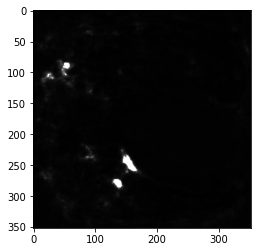


Epoch 00012: val_dice_coef improved from 0.00383 to 0.00483, saving model to weights_save/unet.12_0.00.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0661 - binary_accuracy: 0.9614 - dice_coef: 0.0081 - val_loss: 0.3073 - val_binary_accuracy: 0.8300 - val_dice_coef: 0.0048
Epoch 13/80
400/400 [==============================] - ETA: 0s - loss: 0.0654 - binary_accuracy: 0.9614 - dice_coef: 0.0100------------------------
-------------------------


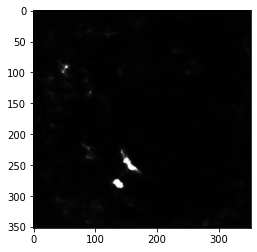


Epoch 00013: val_dice_coef improved from 0.00483 to 0.00741, saving model to weights_save/unet.13_0.01.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0654 - binary_accuracy: 0.9614 - dice_coef: 0.0100 - val_loss: 0.3041 - val_binary_accuracy: 0.8300 - val_dice_coef: 0.0074
Epoch 14/80
400/400 [==============================] - ETA: 0s - loss: 0.0527 - binary_accuracy: 0.9667 - dice_coef: 0.2289------------------------
-------------------------


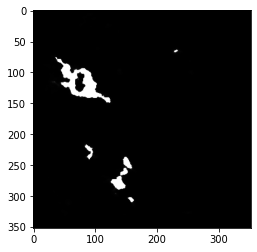


Epoch 00014: val_dice_coef improved from 0.00741 to 0.61141, saving model to weights_save/unet.14_0.61.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0527 - binary_accuracy: 0.9667 - dice_coef: 0.2289 - val_loss: 0.1931 - val_binary_accuracy: 0.8871 - val_dice_coef: 0.6114
Epoch 15/80
400/400 [==============================] - ETA: 0s - loss: 0.0328 - binary_accuracy: 0.9759 - dice_coef: 0.4991------------------------
-------------------------


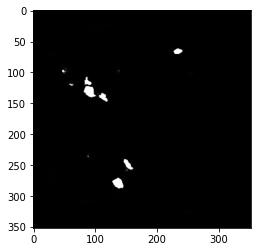


Epoch 00015: val_dice_coef improved from 0.61141 to 0.67987, saving model to weights_save/unet.15_0.68.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0328 - binary_accuracy: 0.9759 - dice_coef: 0.4991 - val_loss: 0.1534 - val_binary_accuracy: 0.9029 - val_dice_coef: 0.6799
Epoch 16/80
400/400 [==============================] - ETA: 0s - loss: 0.0266 - binary_accuracy: 0.9792 - dice_coef: 0.5313------------------------
-------------------------


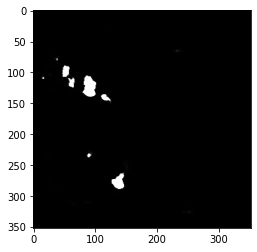


Epoch 00016: val_dice_coef improved from 0.67987 to 0.69779, saving model to weights_save/unet.16_0.70.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0266 - binary_accuracy: 0.9792 - dice_coef: 0.5313 - val_loss: 0.1349 - val_binary_accuracy: 0.9081 - val_dice_coef: 0.6978
Epoch 17/80
400/400 [==============================] - ETA: 0s - loss: 0.0233 - binary_accuracy: 0.9809 - dice_coef: 0.5442------------------------
-------------------------


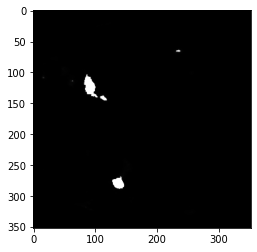


Epoch 00017: val_dice_coef did not improve from 0.69779
400/400 [==============================] - 165s 412ms/step - loss: 0.0233 - binary_accuracy: 0.9809 - dice_coef: 0.5442 - val_loss: 0.1351 - val_binary_accuracy: 0.9085 - val_dice_coef: 0.6977
Epoch 18/80
400/400 [==============================] - ETA: 0s - loss: 0.0218 - binary_accuracy: 0.9817 - dice_coef: 0.5529------------------------
-------------------------


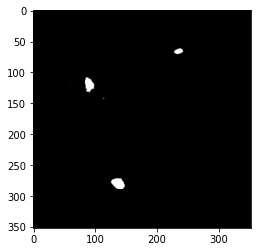


Epoch 00018: val_dice_coef improved from 0.69779 to 0.70219, saving model to weights_save/unet.18_0.70.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0218 - binary_accuracy: 0.9817 - dice_coef: 0.5529 - val_loss: 0.1327 - val_binary_accuracy: 0.9098 - val_dice_coef: 0.7022
Epoch 19/80
400/400 [==============================] - ETA: 0s - loss: 0.0210 - binary_accuracy: 0.9821 - dice_coef: 0.5584------------------------
-------------------------


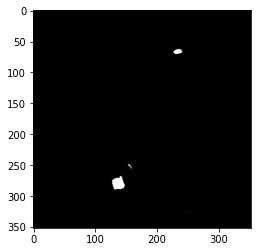


Epoch 00019: val_dice_coef improved from 0.70219 to 0.70382, saving model to weights_save/unet.19_0.70.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0210 - binary_accuracy: 0.9821 - dice_coef: 0.5584 - val_loss: 0.1324 - val_binary_accuracy: 0.9105 - val_dice_coef: 0.7038
Epoch 20/80
400/400 [==============================] - ETA: 0s - loss: 0.0196 - binary_accuracy: 0.9828 - dice_coef: 0.5655------------------------
-------------------------


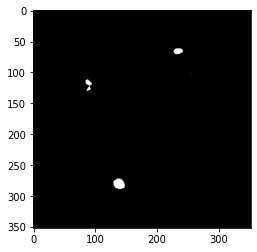


Epoch 00020: val_dice_coef improved from 0.70382 to 0.71754, saving model to weights_save/unet.20_0.72.h5
400/400 [==============================] - 165s 412ms/step - loss: 0.0196 - binary_accuracy: 0.9828 - dice_coef: 0.5655 - val_loss: 0.1201 - val_binary_accuracy: 0.9140 - val_dice_coef: 0.7175
Epoch 21/80
400/400 [==============================] - ETA: 0s - loss: 0.0193 - binary_accuracy: 0.9830 - dice_coef: 0.5706------------------------
-------------------------


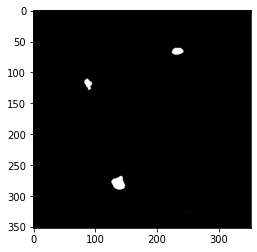


Epoch 00021: val_dice_coef did not improve from 0.71754
400/400 [==============================] - 165s 412ms/step - loss: 0.0193 - binary_accuracy: 0.9830 - dice_coef: 0.5706 - val_loss: 0.1228 - val_binary_accuracy: 0.9127 - val_dice_coef: 0.7171
Epoch 22/80
400/400 [==============================] - ETA: 0s - loss: 0.0186 - binary_accuracy: 0.9833 - dice_coef: 0.5779------------------------
-------------------------


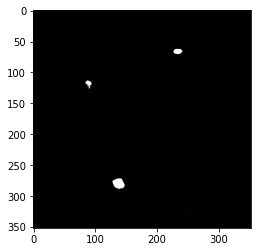


Epoch 00022: val_dice_coef did not improve from 0.71754
400/400 [==============================] - 165s 412ms/step - loss: 0.0186 - binary_accuracy: 0.9833 - dice_coef: 0.5779 - val_loss: 0.1210 - val_binary_accuracy: 0.9141 - val_dice_coef: 0.7166
Epoch 23/80
400/400 [==============================] - ETA: 0s - loss: 0.0180 - binary_accuracy: 0.9837 - dice_coef: 0.5782------------------------
-------------------------


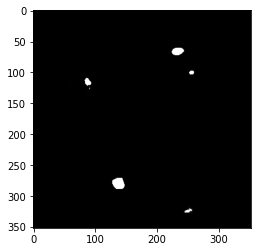


Epoch 00023: val_dice_coef improved from 0.71754 to 0.71774, saving model to weights_save/unet.23_0.72.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0180 - binary_accuracy: 0.9837 - dice_coef: 0.5782 - val_loss: 0.1220 - val_binary_accuracy: 0.9144 - val_dice_coef: 0.7177
Epoch 24/80
400/400 [==============================] - ETA: 0s - loss: 0.0178 - binary_accuracy: 0.9837 - dice_coef: 0.5803------------------------
-------------------------


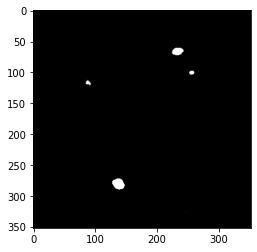


Epoch 00024: val_dice_coef improved from 0.71774 to 0.72791, saving model to weights_save/unet.24_0.73.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0178 - binary_accuracy: 0.9837 - dice_coef: 0.5803 - val_loss: 0.1148 - val_binary_accuracy: 0.9144 - val_dice_coef: 0.7279
Epoch 25/80
400/400 [==============================] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9839 - dice_coef: 0.5855------------------------
-------------------------


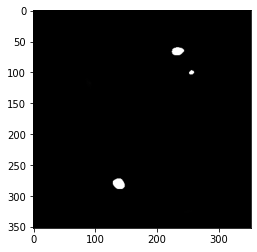


Epoch 00025: val_dice_coef did not improve from 0.72791
400/400 [==============================] - 165s 413ms/step - loss: 0.0175 - binary_accuracy: 0.9839 - dice_coef: 0.5855 - val_loss: 0.1167 - val_binary_accuracy: 0.9146 - val_dice_coef: 0.7234
Epoch 26/80
400/400 [==============================] - ETA: 0s - loss: 0.0176 - binary_accuracy: 0.9838 - dice_coef: 0.5834------------------------
-------------------------


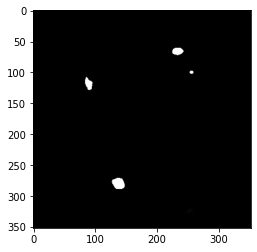


Epoch 00026: val_dice_coef did not improve from 0.72791
400/400 [==============================] - 165s 412ms/step - loss: 0.0176 - binary_accuracy: 0.9838 - dice_coef: 0.5834 - val_loss: 0.1190 - val_binary_accuracy: 0.9144 - val_dice_coef: 0.7195
Epoch 27/80
400/400 [==============================] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9841 - dice_coef: 0.5885------------------------
-------------------------


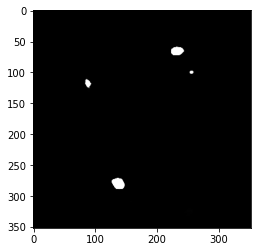


Epoch 00027: val_dice_coef did not improve from 0.72791
400/400 [==============================] - 165s 412ms/step - loss: 0.0171 - binary_accuracy: 0.9841 - dice_coef: 0.5885 - val_loss: 0.1174 - val_binary_accuracy: 0.9139 - val_dice_coef: 0.7213
Epoch 28/80
400/400 [==============================] - ETA: 0s - loss: 0.0169 - binary_accuracy: 0.9842 - dice_coef: 0.5862------------------------
-------------------------


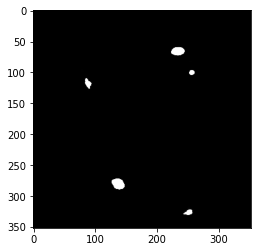


Epoch 00028: val_dice_coef did not improve from 0.72791
400/400 [==============================] - 165s 412ms/step - loss: 0.0169 - binary_accuracy: 0.9842 - dice_coef: 0.5862 - val_loss: 0.1191 - val_binary_accuracy: 0.9154 - val_dice_coef: 0.7206
Epoch 29/80
400/400 [==============================] - ETA: 0s - loss: 0.0168 - binary_accuracy: 0.9841 - dice_coef: 0.5879------------------------
-------------------------


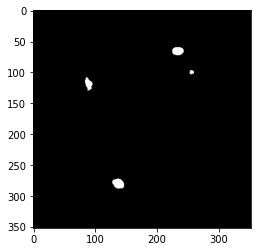


Epoch 00029: val_dice_coef did not improve from 0.72791
400/400 [==============================] - 165s 412ms/step - loss: 0.0168 - binary_accuracy: 0.9841 - dice_coef: 0.5879 - val_loss: 0.1161 - val_binary_accuracy: 0.9160 - val_dice_coef: 0.7239
Epoch 30/80
400/400 [==============================] - ETA: 0s - loss: 0.0168 - binary_accuracy: 0.9841 - dice_coef: 0.5888------------------------
-------------------------


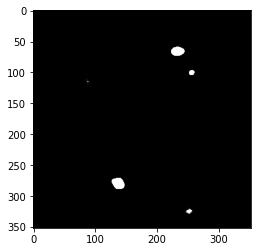


Epoch 00030: val_dice_coef improved from 0.72791 to 0.73084, saving model to weights_save/unet.30_0.73.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0168 - binary_accuracy: 0.9841 - dice_coef: 0.5888 - val_loss: 0.1134 - val_binary_accuracy: 0.9151 - val_dice_coef: 0.7308
Epoch 31/80
400/400 [==============================] - ETA: 0s - loss: 0.0167 - binary_accuracy: 0.9842 - dice_coef: 0.5929------------------------
-------------------------


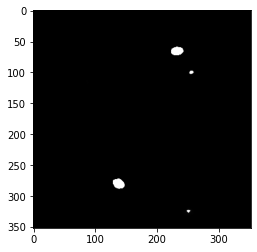


Epoch 00031: val_dice_coef did not improve from 0.73084
400/400 [==============================] - 165s 412ms/step - loss: 0.0167 - binary_accuracy: 0.9842 - dice_coef: 0.5929 - val_loss: 0.1128 - val_binary_accuracy: 0.9158 - val_dice_coef: 0.7267
Epoch 32/80
400/400 [==============================] - ETA: 0s - loss: 0.0163 - binary_accuracy: 0.9844 - dice_coef: 0.5879------------------------
-------------------------


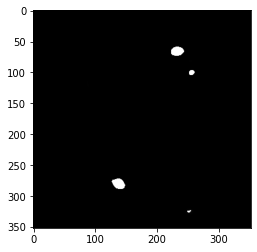


Epoch 00032: val_dice_coef did not improve from 0.73084
400/400 [==============================] - 165s 412ms/step - loss: 0.0163 - binary_accuracy: 0.9844 - dice_coef: 0.5879 - val_loss: 0.1140 - val_binary_accuracy: 0.9158 - val_dice_coef: 0.7253
Epoch 33/80
400/400 [==============================] - ETA: 0s - loss: 0.0162 - binary_accuracy: 0.9844 - dice_coef: 0.5953------------------------
-------------------------


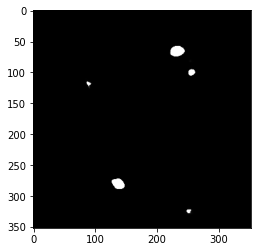


Epoch 00033: val_dice_coef improved from 0.73084 to 0.73085, saving model to weights_save/unet.33_0.73.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0162 - binary_accuracy: 0.9844 - dice_coef: 0.5953 - val_loss: 0.1125 - val_binary_accuracy: 0.9166 - val_dice_coef: 0.7308
Epoch 34/80
400/400 [==============================] - ETA: 0s - loss: 0.0160 - binary_accuracy: 0.9845 - dice_coef: 0.5941------------------------
-------------------------


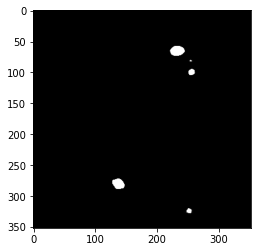


Epoch 00034: val_dice_coef did not improve from 0.73085
400/400 [==============================] - 165s 412ms/step - loss: 0.0160 - binary_accuracy: 0.9845 - dice_coef: 0.5941 - val_loss: 0.1158 - val_binary_accuracy: 0.9158 - val_dice_coef: 0.7245
Epoch 35/80
400/400 [==============================] - ETA: 0s - loss: 0.0160 - binary_accuracy: 0.9845 - dice_coef: 0.5932------------------------
-------------------------


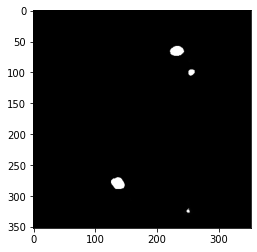


Epoch 00035: val_dice_coef did not improve from 0.73085
400/400 [==============================] - 165s 412ms/step - loss: 0.0160 - binary_accuracy: 0.9845 - dice_coef: 0.5932 - val_loss: 0.1144 - val_binary_accuracy: 0.9155 - val_dice_coef: 0.7296
Epoch 36/80
400/400 [==============================] - ETA: 0s - loss: 0.0161 - binary_accuracy: 0.9845 - dice_coef: 0.5979------------------------
-------------------------


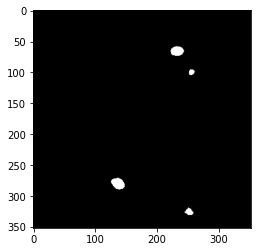


Epoch 00036: val_dice_coef improved from 0.73085 to 0.73306, saving model to weights_save/unet.36_0.73.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0161 - binary_accuracy: 0.9845 - dice_coef: 0.5979 - val_loss: 0.1119 - val_binary_accuracy: 0.9165 - val_dice_coef: 0.7331
Epoch 37/80
400/400 [==============================] - ETA: 0s - loss: 0.0160 - binary_accuracy: 0.9845 - dice_coef: 0.5951------------------------
-------------------------


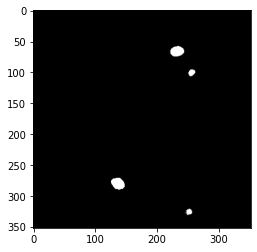


Epoch 00037: val_dice_coef did not improve from 0.73306
400/400 [==============================] - 165s 412ms/step - loss: 0.0160 - binary_accuracy: 0.9845 - dice_coef: 0.5951 - val_loss: 0.1135 - val_binary_accuracy: 0.9165 - val_dice_coef: 0.7323
Epoch 38/80
400/400 [==============================] - ETA: 0s - loss: 0.0159 - binary_accuracy: 0.9845 - dice_coef: 0.5953------------------------
-------------------------


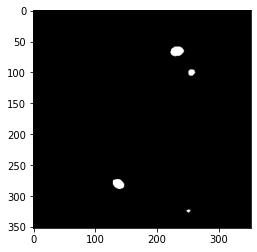


Epoch 00038: val_dice_coef did not improve from 0.73306
400/400 [==============================] - 165s 412ms/step - loss: 0.0159 - binary_accuracy: 0.9845 - dice_coef: 0.5953 - val_loss: 0.1122 - val_binary_accuracy: 0.9174 - val_dice_coef: 0.7298
Epoch 39/80
400/400 [==============================] - ETA: 0s - loss: 0.0156 - binary_accuracy: 0.9847 - dice_coef: 0.5967------------------------
-------------------------


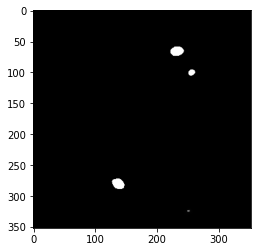


Epoch 00039: val_dice_coef did not improve from 0.73306
400/400 [==============================] - 165s 412ms/step - loss: 0.0156 - binary_accuracy: 0.9847 - dice_coef: 0.5967 - val_loss: 0.1134 - val_binary_accuracy: 0.9158 - val_dice_coef: 0.7313
Epoch 40/80
400/400 [==============================] - ETA: 0s - loss: 0.0157 - binary_accuracy: 0.9847 - dice_coef: 0.5985------------------------
-------------------------


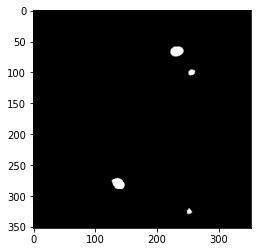


Epoch 00040: val_dice_coef did not improve from 0.73306
400/400 [==============================] - 165s 412ms/step - loss: 0.0157 - binary_accuracy: 0.9847 - dice_coef: 0.5985 - val_loss: 0.1146 - val_binary_accuracy: 0.9159 - val_dice_coef: 0.7282
Epoch 41/80
400/400 [==============================] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9849 - dice_coef: 0.5993------------------------
-------------------------


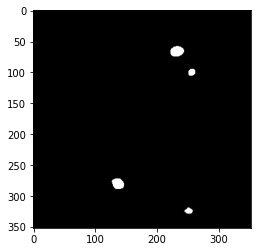


Epoch 00041: val_dice_coef improved from 0.73306 to 0.73650, saving model to weights_save/unet.41_0.74.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0152 - binary_accuracy: 0.9849 - dice_coef: 0.5993 - val_loss: 0.1112 - val_binary_accuracy: 0.9153 - val_dice_coef: 0.7365
Epoch 42/80
400/400 [==============================] - ETA: 0s - loss: 0.0154 - binary_accuracy: 0.9848 - dice_coef: 0.5991------------------------
-------------------------


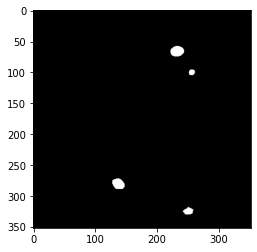


Epoch 00042: val_dice_coef did not improve from 0.73650
400/400 [==============================] - 165s 412ms/step - loss: 0.0154 - binary_accuracy: 0.9848 - dice_coef: 0.5991 - val_loss: 0.1149 - val_binary_accuracy: 0.9157 - val_dice_coef: 0.7295
Epoch 43/80
400/400 [==============================] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9849 - dice_coef: 0.5984------------------------
-------------------------


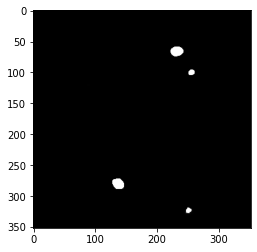


Epoch 00043: val_dice_coef did not improve from 0.73650
400/400 [==============================] - 165s 412ms/step - loss: 0.0153 - binary_accuracy: 0.9849 - dice_coef: 0.5984 - val_loss: 0.1167 - val_binary_accuracy: 0.9142 - val_dice_coef: 0.7228
Epoch 44/80
400/400 [==============================] - ETA: 0s - loss: 0.0156 - binary_accuracy: 0.9847 - dice_coef: 0.6005------------------------
-------------------------


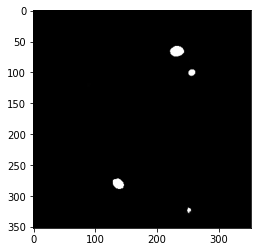


Epoch 00044: val_dice_coef did not improve from 0.73650
400/400 [==============================] - 165s 412ms/step - loss: 0.0156 - binary_accuracy: 0.9847 - dice_coef: 0.6005 - val_loss: 0.1117 - val_binary_accuracy: 0.9161 - val_dice_coef: 0.7309
Epoch 45/80
400/400 [==============================] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9848 - dice_coef: 0.6004------------------------
-------------------------


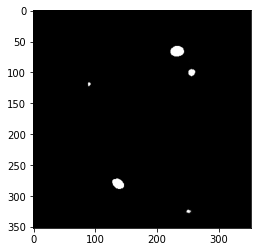


Epoch 00045: val_dice_coef did not improve from 0.73650
400/400 [==============================] - 165s 412ms/step - loss: 0.0152 - binary_accuracy: 0.9848 - dice_coef: 0.6004 - val_loss: 0.1152 - val_binary_accuracy: 0.9145 - val_dice_coef: 0.7261
Epoch 46/80
400/400 [==============================] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9849 - dice_coef: 0.6035------------------------
-------------------------


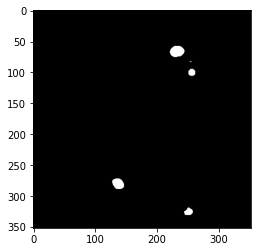


Epoch 00046: val_dice_coef did not improve from 0.73650
400/400 [==============================] - 165s 412ms/step - loss: 0.0152 - binary_accuracy: 0.9849 - dice_coef: 0.6035 - val_loss: 0.1120 - val_binary_accuracy: 0.9154 - val_dice_coef: 0.7342
Epoch 47/80
400/400 [==============================] - ETA: 0s - loss: 0.0151 - binary_accuracy: 0.9849 - dice_coef: 0.6034------------------------
-------------------------


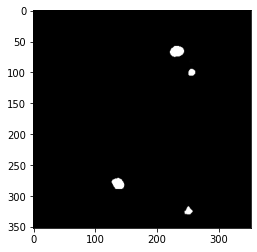


Epoch 00047: val_dice_coef improved from 0.73650 to 0.73680, saving model to weights_save/unet.47_0.74.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0151 - binary_accuracy: 0.9849 - dice_coef: 0.6034 - val_loss: 0.1106 - val_binary_accuracy: 0.9148 - val_dice_coef: 0.7368
Epoch 48/80
400/400 [==============================] - ETA: 0s - loss: 0.0151 - binary_accuracy: 0.9850 - dice_coef: 0.6000------------------------
-------------------------


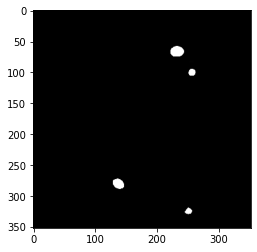


Epoch 00048: val_dice_coef did not improve from 0.73680
400/400 [==============================] - 165s 412ms/step - loss: 0.0151 - binary_accuracy: 0.9850 - dice_coef: 0.6000 - val_loss: 0.1111 - val_binary_accuracy: 0.9175 - val_dice_coef: 0.7349
Epoch 49/80
400/400 [==============================] - ETA: 0s - loss: 0.0148 - binary_accuracy: 0.9851 - dice_coef: 0.6024------------------------
-------------------------


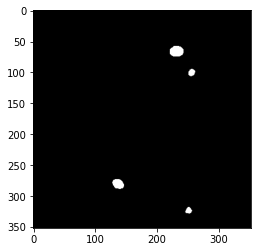


Epoch 00049: val_dice_coef did not improve from 0.73680
400/400 [==============================] - 165s 412ms/step - loss: 0.0148 - binary_accuracy: 0.9851 - dice_coef: 0.6024 - val_loss: 0.1114 - val_binary_accuracy: 0.9176 - val_dice_coef: 0.7291
Epoch 50/80
400/400 [==============================] - ETA: 0s - loss: 0.0146 - binary_accuracy: 0.9852 - dice_coef: 0.6045------------------------
-------------------------


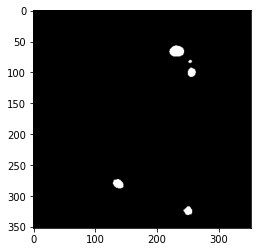


Epoch 00050: val_dice_coef did not improve from 0.73680
400/400 [==============================] - 165s 412ms/step - loss: 0.0146 - binary_accuracy: 0.9852 - dice_coef: 0.6045 - val_loss: 0.1118 - val_binary_accuracy: 0.9181 - val_dice_coef: 0.7272
Epoch 51/80
400/400 [==============================] - ETA: 0s - loss: 0.0150 - binary_accuracy: 0.9849 - dice_coef: 0.6037------------------------
-------------------------


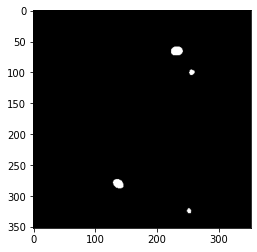


Epoch 00051: val_dice_coef did not improve from 0.73680
400/400 [==============================] - 165s 412ms/step - loss: 0.0150 - binary_accuracy: 0.9849 - dice_coef: 0.6037 - val_loss: 0.1138 - val_binary_accuracy: 0.9183 - val_dice_coef: 0.7268
Epoch 52/80
400/400 [==============================] - ETA: 0s - loss: 0.0148 - binary_accuracy: 0.9851 - dice_coef: 0.6045------------------------
-------------------------


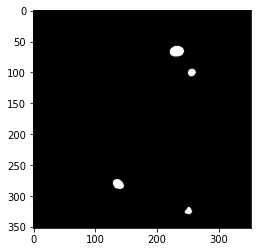


Epoch 00052: val_dice_coef did not improve from 0.73680
400/400 [==============================] - 165s 412ms/step - loss: 0.0148 - binary_accuracy: 0.9851 - dice_coef: 0.6045 - val_loss: 0.1099 - val_binary_accuracy: 0.9171 - val_dice_coef: 0.7330
Epoch 53/80
400/400 [==============================] - ETA: 0s - loss: 0.0145 - binary_accuracy: 0.9852 - dice_coef: 0.6046------------------------
-------------------------


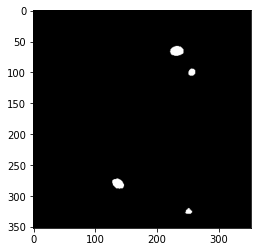


Epoch 00053: val_dice_coef did not improve from 0.73680
400/400 [==============================] - 165s 412ms/step - loss: 0.0145 - binary_accuracy: 0.9852 - dice_coef: 0.6046 - val_loss: 0.1110 - val_binary_accuracy: 0.9172 - val_dice_coef: 0.7353
Epoch 54/80
400/400 [==============================] - ETA: 0s - loss: 0.0145 - binary_accuracy: 0.9852 - dice_coef: 0.6062------------------------
-------------------------


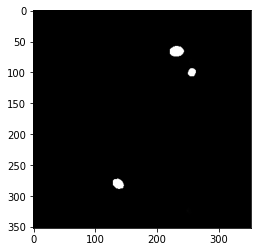


Epoch 00054: val_dice_coef did not improve from 0.73680
400/400 [==============================] - 165s 412ms/step - loss: 0.0145 - binary_accuracy: 0.9852 - dice_coef: 0.6062 - val_loss: 0.1151 - val_binary_accuracy: 0.9162 - val_dice_coef: 0.7214
Epoch 55/80
400/400 [==============================] - ETA: 0s - loss: 0.0147 - binary_accuracy: 0.9851 - dice_coef: 0.6063------------------------
-------------------------


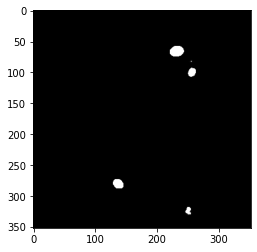


Epoch 00055: val_dice_coef improved from 0.73680 to 0.73774, saving model to weights_save/unet.55_0.74.h5
400/400 [==============================] - 165s 413ms/step - loss: 0.0147 - binary_accuracy: 0.9851 - dice_coef: 0.6063 - val_loss: 0.1083 - val_binary_accuracy: 0.9179 - val_dice_coef: 0.7377
Epoch 56/80
400/400 [==============================] - ETA: 0s - loss: 0.0143 - binary_accuracy: 0.9854 - dice_coef: 0.6064------------------------
-------------------------


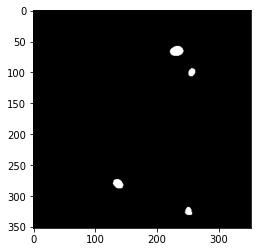


Epoch 00056: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 413ms/step - loss: 0.0143 - binary_accuracy: 0.9854 - dice_coef: 0.6064 - val_loss: 0.1135 - val_binary_accuracy: 0.9172 - val_dice_coef: 0.7289
Epoch 57/80
400/400 [==============================] - ETA: 0s - loss: 0.0143 - binary_accuracy: 0.9853 - dice_coef: 0.6066------------------------
-------------------------


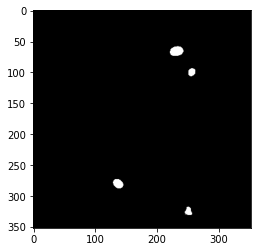


Epoch 00057: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0143 - binary_accuracy: 0.9853 - dice_coef: 0.6066 - val_loss: 0.1129 - val_binary_accuracy: 0.9175 - val_dice_coef: 0.7238
Epoch 58/80
400/400 [==============================] - ETA: 0s - loss: 0.0144 - binary_accuracy: 0.9853 - dice_coef: 0.6070------------------------
-------------------------


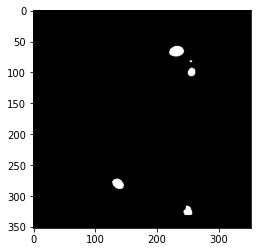


Epoch 00058: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0144 - binary_accuracy: 0.9853 - dice_coef: 0.6070 - val_loss: 0.1084 - val_binary_accuracy: 0.9181 - val_dice_coef: 0.7365
Epoch 59/80
400/400 [==============================] - ETA: 0s - loss: 0.0143 - binary_accuracy: 0.9853 - dice_coef: 0.6070------------------------
-------------------------


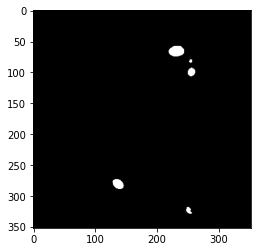


Epoch 00059: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0143 - binary_accuracy: 0.9853 - dice_coef: 0.6070 - val_loss: 0.1133 - val_binary_accuracy: 0.9162 - val_dice_coef: 0.7274
Epoch 60/80
400/400 [==============================] - ETA: 0s - loss: 0.0144 - binary_accuracy: 0.9852 - dice_coef: 0.6095------------------------
-------------------------


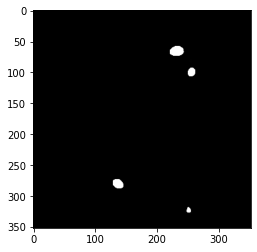


Epoch 00060: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0144 - binary_accuracy: 0.9852 - dice_coef: 0.6095 - val_loss: 0.1133 - val_binary_accuracy: 0.9164 - val_dice_coef: 0.7270
Epoch 61/80
400/400 [==============================] - ETA: 0s - loss: 0.0141 - binary_accuracy: 0.9854 - dice_coef: 0.6075------------------------
-------------------------


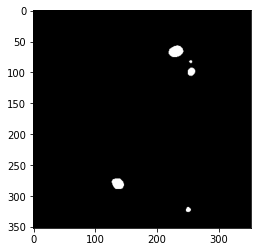


Epoch 00061: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0141 - binary_accuracy: 0.9854 - dice_coef: 0.6075 - val_loss: 0.1120 - val_binary_accuracy: 0.9166 - val_dice_coef: 0.7292
Epoch 62/80
400/400 [==============================] - ETA: 0s - loss: 0.0145 - binary_accuracy: 0.9852 - dice_coef: 0.6090------------------------
-------------------------


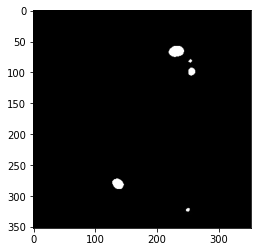


Epoch 00062: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0145 - binary_accuracy: 0.9852 - dice_coef: 0.6090 - val_loss: 0.1117 - val_binary_accuracy: 0.9160 - val_dice_coef: 0.7314
Epoch 63/80
400/400 [==============================] - ETA: 0s - loss: 0.0140 - binary_accuracy: 0.9855 - dice_coef: 0.6079------------------------
-------------------------


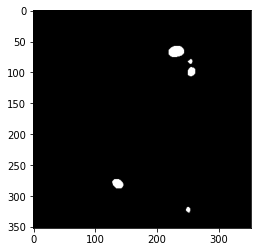


Epoch 00063: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0140 - binary_accuracy: 0.9855 - dice_coef: 0.6079 - val_loss: 0.1109 - val_binary_accuracy: 0.9169 - val_dice_coef: 0.7319
Epoch 64/80
400/400 [==============================] - ETA: 0s - loss: 0.0141 - binary_accuracy: 0.9854 - dice_coef: 0.6081------------------------
-------------------------


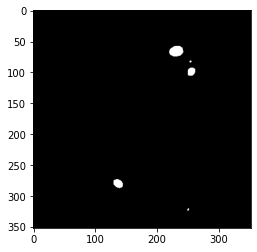


Epoch 00064: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0141 - binary_accuracy: 0.9854 - dice_coef: 0.6081 - val_loss: 0.1173 - val_binary_accuracy: 0.9157 - val_dice_coef: 0.7179
Epoch 65/80
400/400 [==============================] - ETA: 0s - loss: 0.0144 - binary_accuracy: 0.9853 - dice_coef: 0.6116------------------------
-------------------------


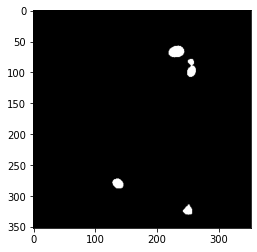


Epoch 00065: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0144 - binary_accuracy: 0.9853 - dice_coef: 0.6116 - val_loss: 0.1147 - val_binary_accuracy: 0.9161 - val_dice_coef: 0.7258
Epoch 66/80
400/400 [==============================] - ETA: 0s - loss: 0.0142 - binary_accuracy: 0.9854 - dice_coef: 0.6104------------------------
-------------------------


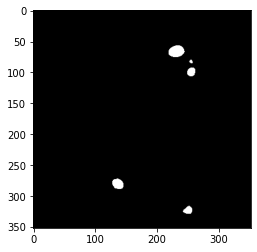


Epoch 00066: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0142 - binary_accuracy: 0.9854 - dice_coef: 0.6104 - val_loss: 0.1137 - val_binary_accuracy: 0.9157 - val_dice_coef: 0.7292
Epoch 67/80
400/400 [==============================] - ETA: 0s - loss: 0.0142 - binary_accuracy: 0.9853 - dice_coef: 0.6111------------------------
-------------------------


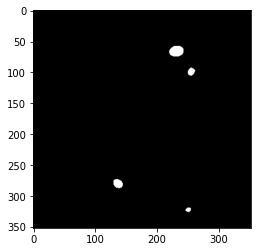


Epoch 00067: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0142 - binary_accuracy: 0.9853 - dice_coef: 0.6111 - val_loss: 0.1146 - val_binary_accuracy: 0.9160 - val_dice_coef: 0.7246
Epoch 68/80
400/400 [==============================] - ETA: 0s - loss: 0.0138 - binary_accuracy: 0.9856 - dice_coef: 0.6125------------------------
-------------------------


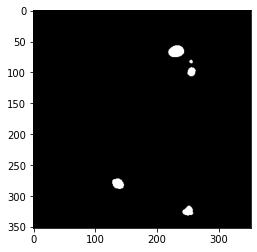


Epoch 00068: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0138 - binary_accuracy: 0.9856 - dice_coef: 0.6125 - val_loss: 0.1196 - val_binary_accuracy: 0.9143 - val_dice_coef: 0.7177
Epoch 69/80
400/400 [==============================] - ETA: 0s - loss: 0.0143 - binary_accuracy: 0.9853 - dice_coef: 0.6091------------------------
-------------------------


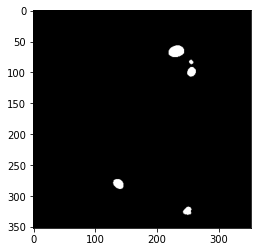


Epoch 00069: val_dice_coef did not improve from 0.73774
400/400 [==============================] - 165s 412ms/step - loss: 0.0143 - binary_accuracy: 0.9853 - dice_coef: 0.6091 - val_loss: 0.1114 - val_binary_accuracy: 0.9166 - val_dice_coef: 0.7319
Epoch 70/80
241/400 [=================>............] - ETA: 1:04 - loss: 0.0139 - binary_accuracy: 0.9856 - dice_coef: 0.6050

KeyboardInterrupt: ignored

In [11]:
input_shape = (h, w, 3)
img = imgs[:1]
#plt.imshow(imgs[0,:,:,:].astype("uint8"),cmap='gray')
#plt.show()
model = unet(input_shape,2)
model.compile(optimizer = SGD(lr = 0.01, momentum = 0.9), loss = {"main_output":Active_Contour_Loss}, 
              metrics = {"main_output":[tf.keras.metrics.BinaryAccuracy(threshold=0),dice_coef]})


checkpoint = ModelCheckpoint('weights_save/unet.{epoch:02d}_{val_dice_coef:.2f}.h5', 
                             monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
#lr_decay = lr_scheduler()
callback_list = [visualize(img),checkpoint]
history = model.fit(train_generator, steps_per_epoch = imgs.shape[0]//4, epochs = 80, 
                    validation_data = (img_dev, mask_dev),callbacks = callback_list,verbose = 1)

Ket qua
Dung ham heviside active contour loss
epoch 35

loss: 0.0307 - accuracy: 0.9623 - dice_coef: 0.9258 - val_loss: 0.0351 - val_accuracy: 0.9655 - val_dice_coef: 0.9212

#visualize 

In [ ]:
def dice_coef2(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    print(y_true_f.shape,y_pred_f.shape)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss2(y_true, y_pred):
    return 1-dice_coef2(y_true, y_pred)

In [ ]:
mask_pred = model.predict(img_dev)
mask_pred = heviside(mask_pred)
plt.imshow(mask_pred[1,:,:,0],cmap= 'gray')
plt.show()    
plt.imshow(mask_dev[1,:,:,0],cmap= 'gray')
plt.show()
#mask_pred[mask_pred<0] = 0
#mask_pred[mask_pred>0] = 1

In [ ]:
np.mean(np.sum(mask_dev[0]*mask_pred[0])*2/(np.sum(mask_dev[0])+np.sum(mask_pred[0])),axis = 0)

In [ ]:
#mask_dev = heviside(mask_dev)
#print(dice_coef_loss2(mask_dev[:1],mask_pred[:1]))
print(dice_coef_loss(mask_dev[1:2],mask_pred[2:3]))

In [ ]:
model = unet(input_shape,2)
model.load_weights("weights_save/attention_unet.h5")

In [ ]:
model.summary()

In [ ]:
for count,layer in enumerate(model.layers):
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	print(count, layer.name)
	filters, biases = layer.get_weights()


In [ ]:
ixs = [2, 5, 9, 91, 94,97]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
pyplot.imshow(imgs[0,:,:,:].astype("uint8"),cmap='gray')
pyplot.show()
feature_maps = model.predict(imgs[:1,:,:,:])
# plot the output from each block
square = 2
for fmap in feature_maps:
    print(fmap.shape)
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            if ix > fmap.shape[-1]:
                continue
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
	# show the figure
    pyplot.show()

In [ ]:
#plt.figure(1)
#plt.subplot(121,aspect='auto')
y=history.history['val_dice_coef']
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model DCS')
plt.ylabel('DCS')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#plt.subplot(122,aspect='auto')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
